In [105]:
# !pip install levenshtein
# !pip install fuzzywuzzy

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process

In [4]:
drinks = pd.read_csv('WHO_data_alc.csv', low_memory=False, header=0)

In [5]:
drinks.columns

Index(['IndicatorCode', 'Indicator', 'ValueType', 'ParentLocationCode',
       'ParentLocation', 'Location type', 'SpatialDimValueCode', 'Location',
       'Period type', 'Period', 'IsLatestYear', 'Dim1 type', 'Dim1',
       'Dim1ValueCode', 'Dim2 type', 'Dim2', 'Dim2ValueCode', 'Dim3 type',
       'Dim3', 'Dim3ValueCode', 'DataSourceDimValueCode', 'DataSource',
       'FactValueNumericPrefix', 'FactValueNumeric', 'FactValueUoM',
       'FactValueNumericLowPrefix', 'FactValueNumericLow',
       'FactValueNumericHighPrefix', 'FactValueNumericHigh', 'Value',
       'FactValueTranslationID', 'FactComments', 'Language', 'DateModified'],
      dtype='object')

Location = Country

Period = year

Dim1 = Alcohol cateogory

FactValueNumeric = Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)

In [432]:
df = drinks[['Location', 'Period', 'Dim1', 'FactValueNumeric', 'FactValueNumericLow','FactValueNumericHigh']]
df

,Location,Period,Dim1,FactValueNumeric,FactValueNumericLow,FactValueNumericHigh
0,Afghanistan,2019,Beer,0.00,0.0,0.0
1,Afghanistan,2019,Other alcoholic beverages,0.00,0.0,0.0
2,Afghanistan,2019,Wine,0.00,0.0,0.0
3,Algeria,2019,Other alcoholic beverages,0.00,0.0,0.0
4,Andorra,2019,Other alcoholic beverages,0.00,0.0,0.0
...,...,...,...,...,...,...
47784,United States of America,1960,Spirits,3.26,NaN,NaN
47785,United States of America,1960,Beer,3.75,NaN,NaN
47786,Austria,1960,Beer,4.70,NaN,NaN
47787,United States of America,1960,All types,7.83,NaN,NaN


<AxesSubplot:>

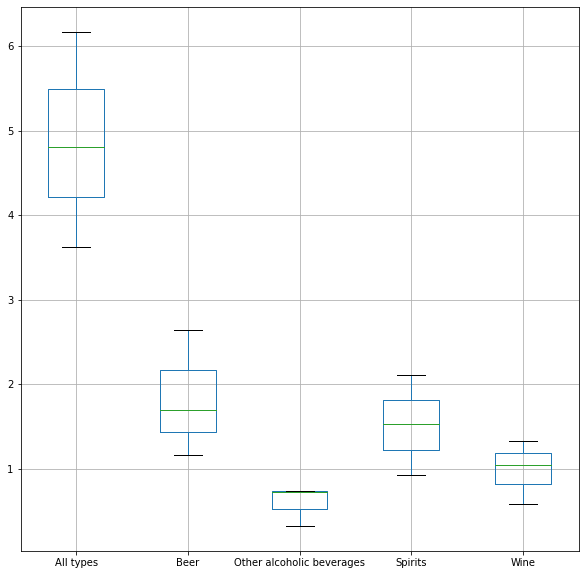

In [320]:
df.drop(['Period'], axis=1).groupby('Dim1').mean().T.boxplot(figsize=(10,10))

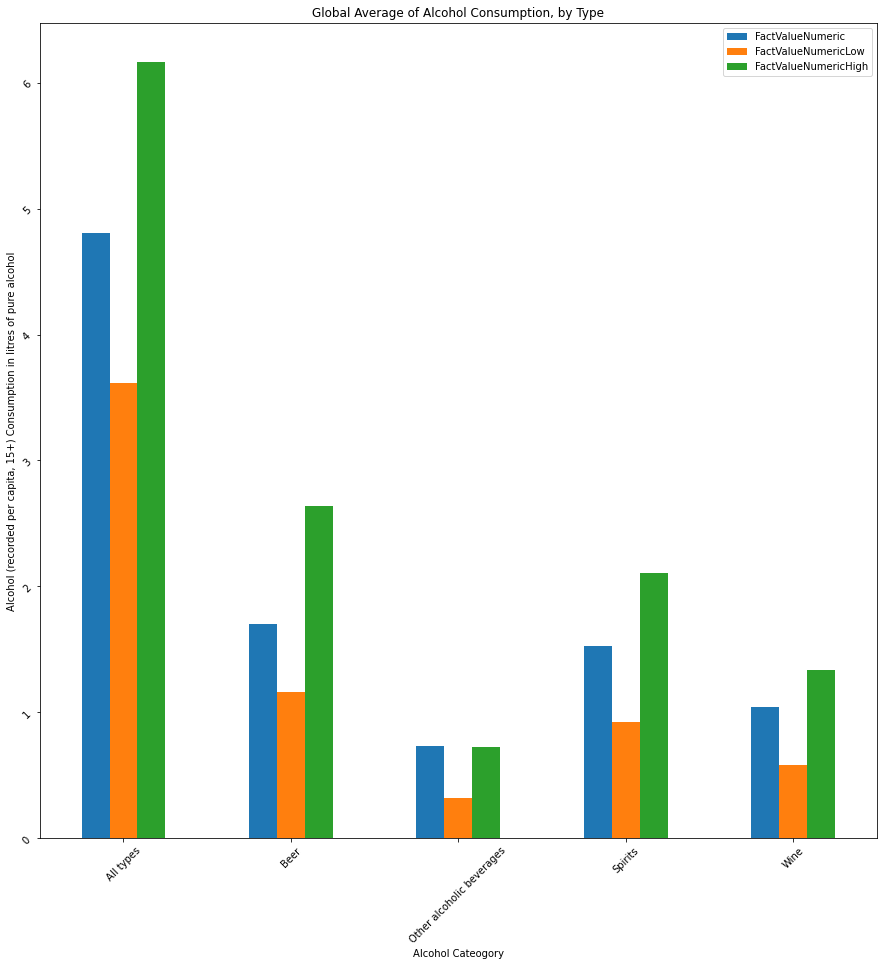

In [8]:
ax = df.drop(['Period'], axis=1).groupby('Dim1').mean().plot(kind='bar', figsize=(15,15), title='Global Average of Alcohol Consumption, by Type', 
                                                        ylabel='Alcohol (recorded per capita, 15+) Consumption in litres of pure alcohol', xlabel='Alcohol Cateogory')

ax.tick_params(rotation=45)

In [147]:
all_types = df[df['Dim1'] == 'All types'].drop(['Dim1','FactValueNumericLow', 'FactValueNumericHigh'], axis=1).rename(columns={'FactValueNumeric':'All Types Volume'})
beer = df[df['Dim1'] == 'Beer'].drop(['Dim1','FactValueNumericLow', 'FactValueNumericHigh'], axis=1).rename(columns={'FactValueNumeric':'Beer Volume'})
wine = df[df['Dim1'] == 'Wine'].drop(['Dim1','FactValueNumericLow', 'FactValueNumericHigh'], axis=1).rename(columns={'FactValueNumeric':'Wine Volume'})
spirits = df[df['Dim1'] == 'Spirits'].drop(['Dim1','FactValueNumericLow', 'FactValueNumericHigh'], axis=1).rename(columns={'FactValueNumeric':'Spirits Volume'})
other = df[df['Dim1'] == 'Other alcoholic beverages'].drop(['Dim1','FactValueNumericLow', 'FactValueNumericHigh'], axis=1).rename(columns={'FactValueNumeric':'Other Volume'})

<AxesSubplot:xlabel='Period'>

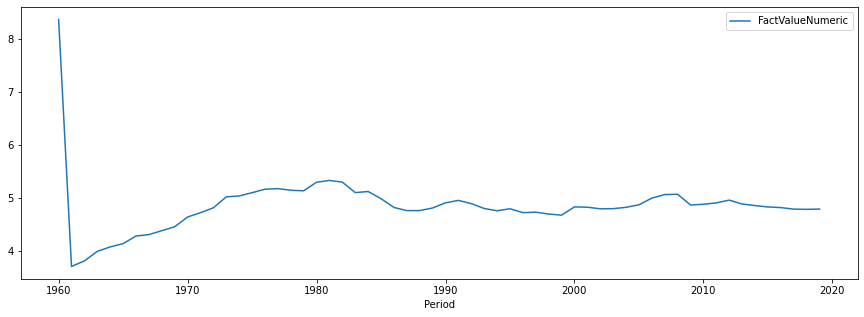

In [124]:
all_types.groupby('Period').mean().plot(kind='line', figsize=(15,5))

In [403]:
gdp_pc = pd.read_csv('gdp_per_capita.csv')
gdp_pc = gdp_pc.rename(columns={'Country Name':'Location'})

In [404]:
gdp_pc

,Location,Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24712.493263,26441.619936,26893.011506,28396.908423,28452.170615,29350.805019,30253.279358,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,147.612227,147.014904,156.189192,182.243917,162.347592,180.214908,190.845484,192.337167,...,1736.166560,1713.899299,1703.596298,1549.037940,1431.778723,1573.063386,1574.978648,1530.059177,1359.618224,NaN
2,Afghanistan,AFG,59.773234,59.860900,58.458009,78.706429,82.095307,101.108325,137.594298,160.898434,...,638.845852,624.315455,614.223342,556.007221,512.012778,516.679862,485.668419,494.179350,516.747871,NaN
3,Africa Western and Central,AFW,107.932233,113.081647,118.831107,123.442888,131.854402,138.526332,144.326212,128.582470,...,1965.118485,2157.481149,2212.853135,1894.310195,1673.835527,1613.473553,1704.139603,1777.918672,1710.073363,NaN
4,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5100.097027,5254.881126,5408.411700,4166.979833,3506.073128,4095.810057,3289.643995,2809.626088,1776.166868,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3410.859780,3704.784221,3902.676013,3520.766449,3759.560246,4009.380987,4384.048892,4416.108358,4346.637931,NaN
262,"Yemen, Rep.",YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1446.536472,1607.152173,1674.002572,1601.830063,1152.720966,964.264811,758.145242,NaN,NaN,NaN
263,South Africa,ZAF,443.009920,454.962013,473.011405,511.497364,548.996058,584.704163,621.220543,675.135345,...,8222.197279,7467.079185,6988.808739,6259.839681,5756.965741,6690.939847,7005.095413,6624.761865,5655.867654,NaN
264,Zambia,ZMB,232.188564,220.042067,212.578449,213.896759,242.384473,303.281740,343.373670,360.201239,...,1763.069442,1878.346811,1762.427817,1338.290927,1280.806543,1535.196574,1516.368371,1305.001031,985.132436,NaN


In [433]:
def NameFinder(name):
    countries = gdp_pc['Location'].drop_duplicates().to_list() + df['Location'].drop_duplicates().to_list()
    gdp_name, alc_name = process.extract(name, countries, limit=2)
    print('Country Name in GDP Dataset', gdp_name, 'Country Name in Alc Dataset', alc_name)
    return gdp_name,alc_name

In [473]:
gdp_locs = gdp_pc['Location'].drop_duplicates().to_list()
alc_locs = df['Location'].drop_duplicates().to_list()
len(gdp_locs), len(alc_locs)

closest_match=[]
for i in gdp_locs:
    fm = process.extract(i, alc_locs, limit=1)
    closest_match.append([i, fm[0]])

non_match=[]
for i in closest_match:
    if i[1][1] < 100:
        non_match.append(i)

print(len(non_match))

96


In [475]:
g, a = NameFinder("Bahamas")

Country Name in GDP Dataset ('Bahamas', 100) Country Name in Alc Dataset ('Bahamas, The', 90)


In [476]:
gdp_pc.loc[gdp_pc['Location'] == g[0], 'Location'] = a[0]

In [94]:
def CountryGDP(country):
    country_gdp = gdp_pc[gdp_pc['Country Name'] == country].T.drop(['Country Name', 'Code', 'Unnamed: 65'])
    country_gdp['Year'] = country_gdp.index
    country_gdp['Year'] = country_gdp['Year'].astype(int)
    country_gdp.columns = ['GDP', 'Year']
    country_gdp = country_gdp.reset_index()
    country_gdp = country_gdp.drop(['index'], axis=1)
    return country_gdp

In [149]:
def CountryConspumtion(country):
    country_cons = df[df['Location'] == country][['Period', 'Dim1','FactValueNumeric']].reset_index().drop(['index'], axis=1)
    country_cons.columns = ['Year', 'Alcohol Type','alc_cons_litre']
    country_cons = country_cons.sort_values('Year')
    return country_cons

In [150]:
usa_gdp = CountryGDP('United States')
usa_consumption = CountryConspumtion('United States of America')

In [17]:
gbr_gdp = CountryGDP('United Kingdom')
gbr_consumption = CountryConspumtion('United Kingdom of Great Britain and Northern Ireland')

In [18]:
ukr_gdp = CountryGDP('Ukraine')
ukr_consumption = CountryConspumtion('Ukraine')

In [32]:
china_gdp = CountryGDP('China')
china_consumption = CountryConspumtion('China')

In [29]:
def TwoAxisPlot(df1, df2, country):
    x1 = np.arange(0, len(df1), step=1)
    y1 = df1['GDP'].to_list()
    x2 = np.arange(0, len(df2), step=1)
    y2 = df2['alc_cons_litre'].to_list()
    years = df2['Year'].to_list()

    fig, ax = plt.subplots(figsize=(16,8))

    color = 'tab:red'
    ax.set_ylabel('GDP', color=color)
    ax.plot(x1, y1, color=color, label='GDP')
    ax.tick_params(axis='y', labelcolor=color)
    ax2 = ax.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Alcohol Consumption', color=color)
    ax2.plot(x2, y2, color=color, label='Alcohol Consumption')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()

    ax.set_xticks(np.arange(len(df2)))
    ax.set_xticklabels(years)
    ax.tick_params(labelrotation=45)
    ax.set_title(f'Normalised GDP vs Total Alcohol Consumption, {country}')
    return

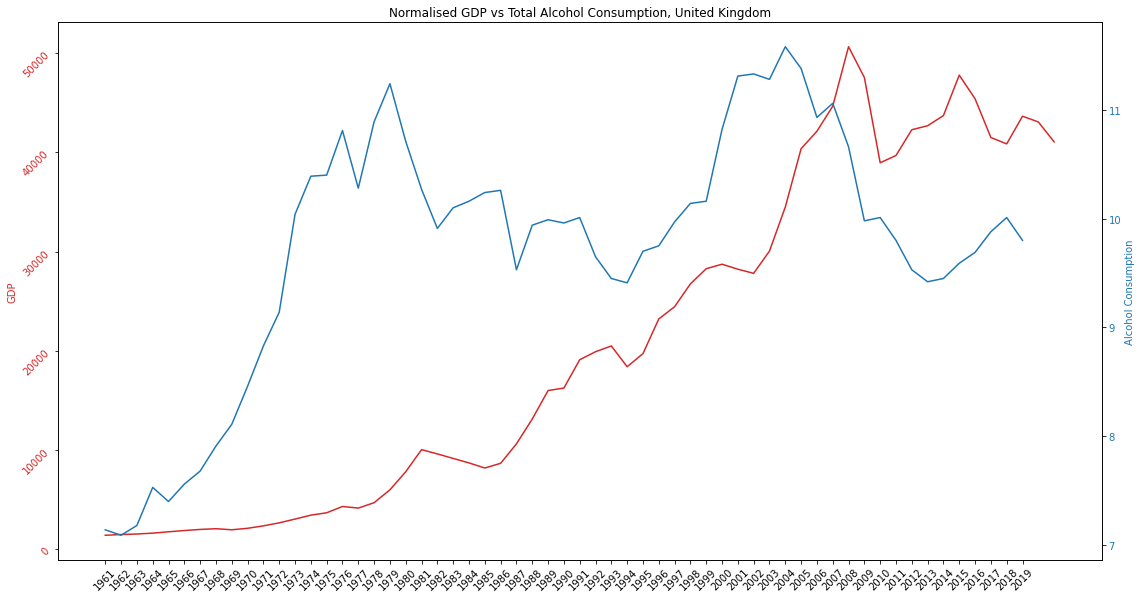

In [30]:
TwoAxisPlot(gbr_gdp, gbr_consumption, 'United Kingdom')

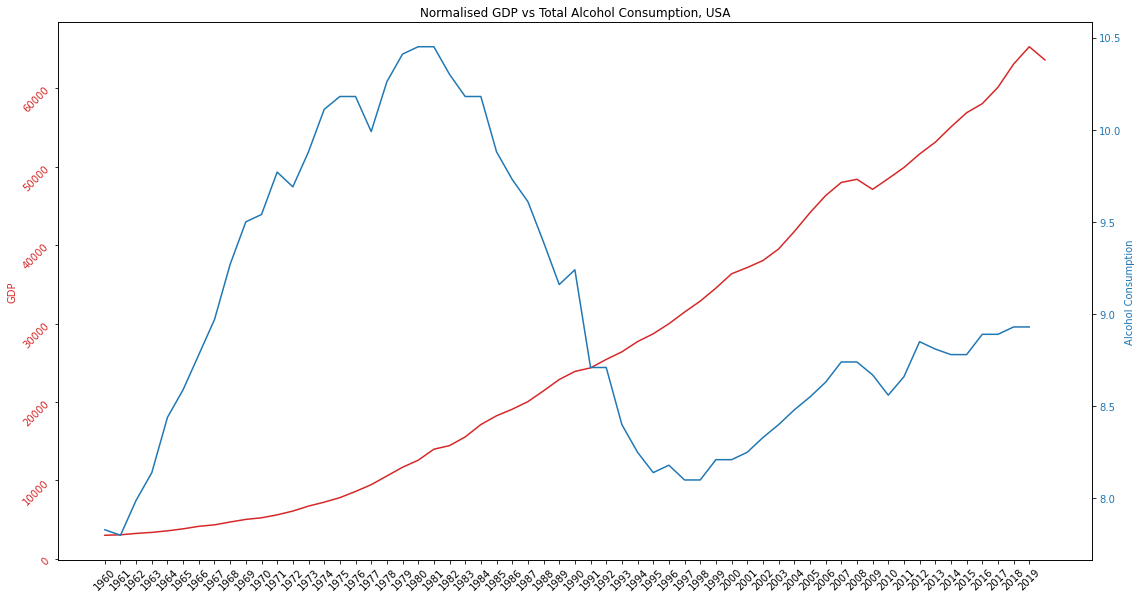

In [27]:
TwoAxisPlot(usa_gdp, usa_consumption, 'USA')

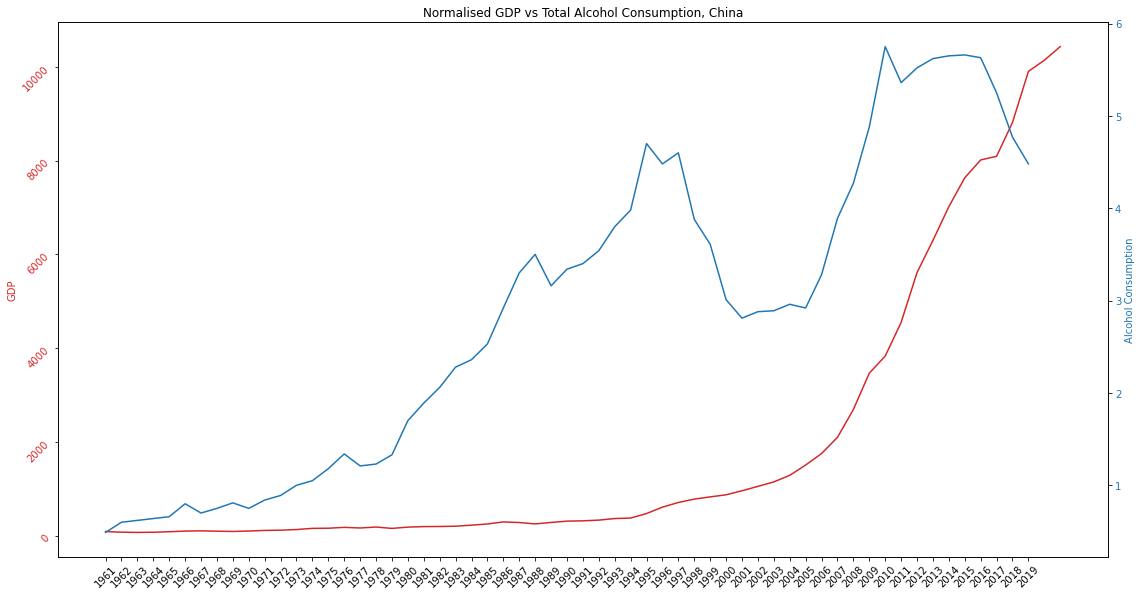

In [33]:
TwoAxisPlot(china_gdp, china_consumption, 'China')

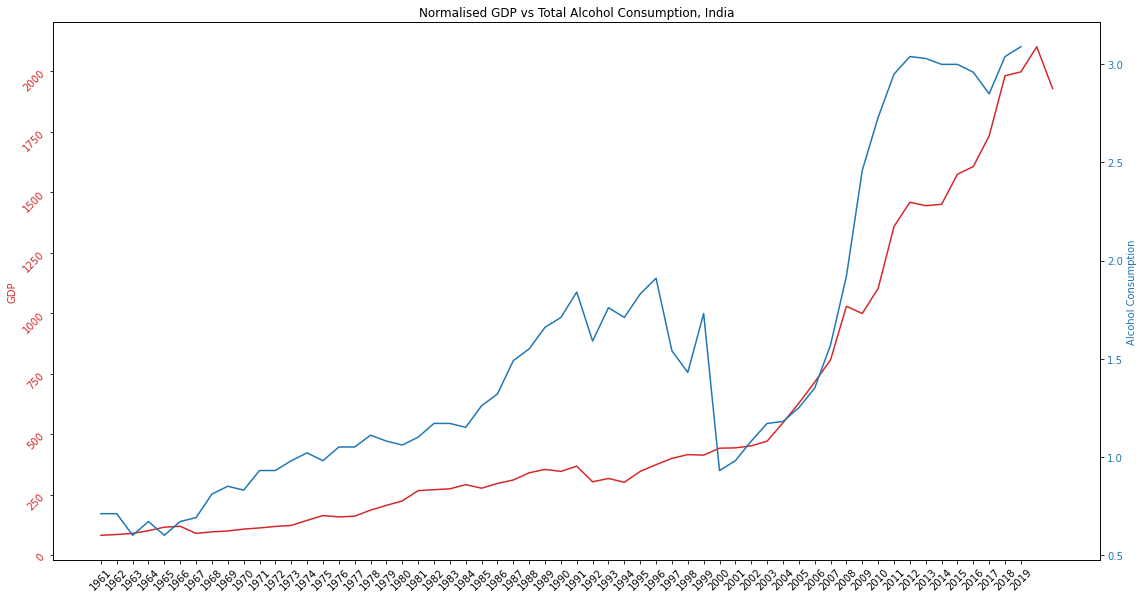

In [34]:
india_gdp = CountryGDP('India')
india_consumption = CountryConspumtion('India')
TwoAxisPlot(india_gdp, india_consumption, 'India')

ML Section

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

import seaborn as sns
import matplotlib.pyplot as plt

In [454]:
# gdp_pc = gdp_pc.rename(columns={'Country Name':'Location'})
# gdp_pc = gdp_pc.drop(['Code'], axis=1)

KeyError: "['Code'] not found in axis"

In [477]:
merged_df = all_types.merge(beer).merge(wine).merge(spirits).merge(other)
merged_df = merged_df.sort_values(by=['Location', 'Period'])
merged_df = merged_df.reset_index().drop(['index'], axis=1)
merged_df

,Location,Period,All Types Volume,Beer Volume,Wine Volume,Spirits Volume,Other Volume
0,Afghanistan,1961,0.00,0.00,0.00,0.00,0.00
1,Afghanistan,1962,0.00,0.00,0.00,0.00,0.00
2,Afghanistan,1963,0.00,0.00,0.00,0.00,0.00
3,Afghanistan,1964,0.00,0.00,0.00,0.00,0.00
4,Afghanistan,1965,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...
7463,Zimbabwe,2015,3.84,1.93,0.06,0.36,1.49
7464,Zimbabwe,2016,3.76,1.93,0.05,0.35,1.44
7465,Zimbabwe,2017,3.82,1.93,0.05,0.39,1.45
7466,Zimbabwe,2018,3.10,1.20,0.04,0.39,1.47


In [478]:
# fix this as countries not all named the same

gdp_pc_filt = gdp_pc.loc[gdp_pc['Location'].isin(merged_df['Location'])].drop(['2020','Unnamed: 65'], axis=1)

In [490]:
len(gdp_pc_filt['Location']), len(merged_df['Location'].drop_duplicates())

(170, 189)

In [480]:
gdp_T = gdp_pc_filt.T
gdp_T = gdp_T.rename(columns=gdp_T.iloc[0])
gdp_T = gdp_T.iloc[1:,:]
gdp_T = gdp_T.reset_index().rename(columns={'index': 'Period'})
gdp_T.head()

,Period,Afghanistan,Angola,Albania,Andorra,United Arab Emirates,Argentina,Armenia,Antigua and Barbuda,Australia,...,United States of America,Uzbekistan,Saint Vincent and the Grenadines,Venezuela (Bolivarian Republic of),Viet Nam,Vanuatu,Samoa,South Africa,Zambia,Zimbabwe
0,1960,59.7732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1810.62,...,3007.12,NaN,161.375,955.446,NaN,NaN,NaN,443.01,232.189,278.814
1,1961,59.8609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1877.62,...,3066.56,NaN,170.381,970.356,NaN,NaN,NaN,454.962,220.042,280.829
2,1962,58.458,NaN,NaN,NaN,NaN,1155.89,NaN,NaN,1854.66,...,3243.84,NaN,174.496,1023.36,NaN,NaN,NaN,473.011,212.578,276.688
3,1963,78.7064,NaN,NaN,NaN,NaN,850.305,NaN,NaN,1967.12,...,3374.52,NaN,162.805,1077.4,NaN,NaN,NaN,511.497,213.897,277.48
4,1964,82.0953,NaN,NaN,NaN,NaN,1173.24,NaN,NaN,2131.38,...,3573.94,NaN,173.387,864.471,NaN,NaN,NaN,548.996,242.384,281.559


In [481]:
years = gdp_T.Period.to_list()

In [482]:
locs = gdp_T.columns.to_list()
pop = locs.pop(0)

In [483]:
df_list=[]
for i in locs:
    df_l = pd.DataFrame(list(zip(years, gdp_T[i].to_list())), columns=['Period', 'GDP'])
    df_l['Location'] = i
    df_list.append(df_l)

print(len(df_list))

170


In [484]:
gdp_concat = pd.concat(df_list)
gdp_concat['Period'] = gdp_concat['Period'].astype(int)
gdp_concat

,Period,GDP,Location
0,1960,59.773234,Afghanistan
1,1961,59.860900,Afghanistan
2,1962,58.458009,Afghanistan
3,1963,78.706429,Afghanistan
4,1964,82.095307,Afghanistan
...,...,...,...
55,2015,1445.069702,Zimbabwe
56,2016,1464.588957,Zimbabwe
57,2017,1235.189032,Zimbabwe
58,2018,1254.642265,Zimbabwe


In [534]:
final_merge = merged_df.merge(gdp_concat)
final_merge = final_merge.dropna()
final_merge

,Location,Period,All Types Volume,Beer Volume,Wine Volume,Spirits Volume,Other Volume,GDP
0,Afghanistan,1961,0.00,0.00,0.00,0.00,0.00,59.860900
1,Afghanistan,1962,0.00,0.00,0.00,0.00,0.00,58.458009
2,Afghanistan,1963,0.00,0.00,0.00,0.00,0.00,78.706429
3,Afghanistan,1964,0.00,0.00,0.00,0.00,0.00,82.095307
4,Afghanistan,1965,0.00,0.00,0.00,0.00,0.00,101.108325
...,...,...,...,...,...,...,...,...
6707,Zimbabwe,2015,3.84,1.93,0.06,0.36,1.49,1445.069702
6708,Zimbabwe,2016,3.76,1.93,0.05,0.35,1.44,1464.588957
6709,Zimbabwe,2017,3.82,1.93,0.05,0.39,1.45,1235.189032
6710,Zimbabwe,2018,3.10,1.20,0.04,0.39,1.47,1254.642265


<AxesSubplot:>

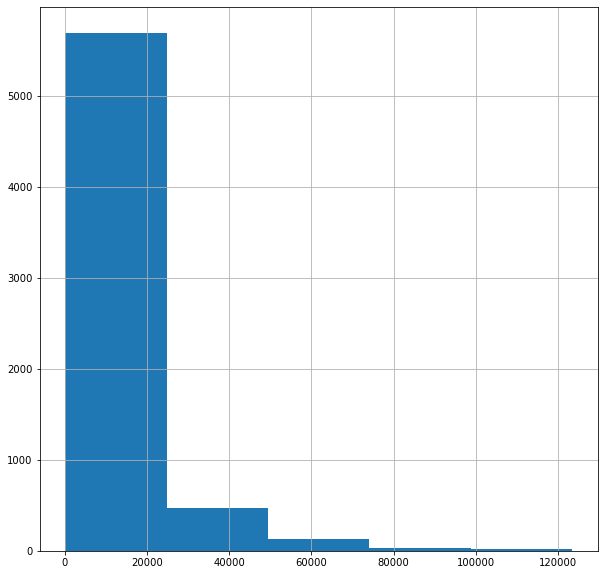

In [551]:
final_merge['GDP'].hist(figsize=(10,10), bins=5)

In [535]:
print('Total Countries with Data', len(final_merge['Location'].drop_duplicates()))

Total Countries with Data 170


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

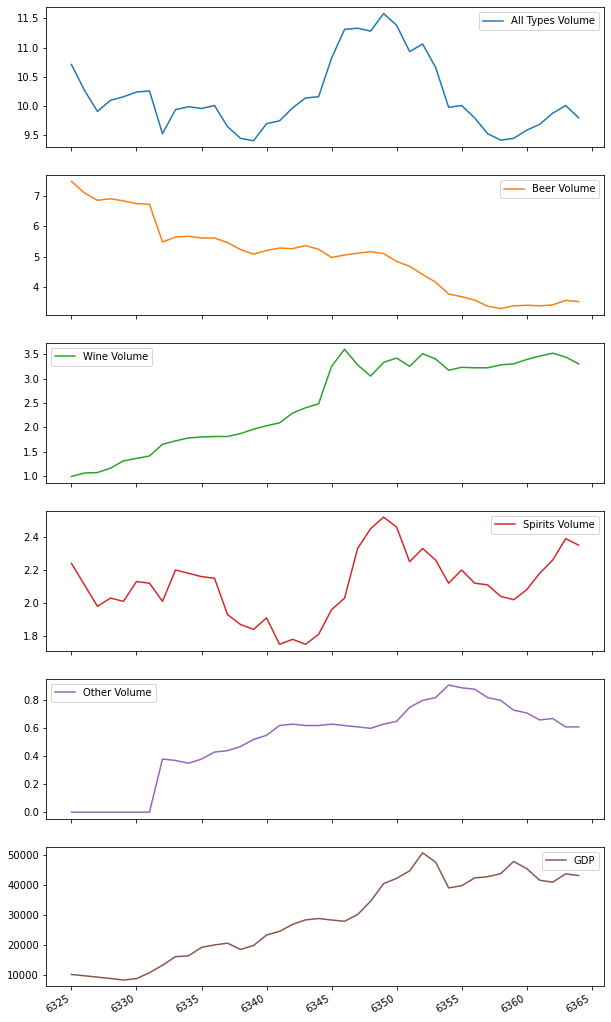

In [536]:
final_merge[final_merge['Location'] == 'United Kingdom of Great Britain and Northern Ireland'].drop(['Period'], axis=1).plot(kind='line', figsize=(10,20), subplots=True)

Unsupervised

In [562]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans

In [558]:
X = final_merge.drop(columns=['Location', 'GDP'])
y = final_merge['GDP']

In [559]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [560]:
X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

In [564]:
kmeans = KMeans(n_clusters = 3, random_state = 0, n_init='auto')
kmeans.fit(X_train_norm)

AttributeError: 'NoneType' object has no attribute 'split'